## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

### Целевая переменная:
* Price

### Метрика качества:
* R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).







### Подключение библитотек и скриптов

In [3]:

import numpy as np
import pandas as pd
import pickle  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, KFold, GridSearchCV


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from IPython.display import Image

In [4]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

### Загрузка данных
    
##### Описание датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [114]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

###  EDA и очистка данных  

In [7]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [8]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [9]:
train.tail(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [10]:
test.tail(2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [22]:
train.shape[1]-1 == test.shape[1]

True

In [23]:
test.shape

(5000, 19)

In [24]:
train.shape

(10000, 20)

In [25]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [26]:
test.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [27]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [28]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

#### Приведение типов данных

In [123]:
train.dtypes

Id                     object
DistrictId             object
Rooms                 float64
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int64
HouseFloor            float64
HouseYear               int64
Ecology_1             float64
Ecology_2              object
Ecology_3              object
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
Shops_2                object
Price                 float64
Ecology_2_bin           int64
Ecology_3_bin           int64
Shops_2_bin             int64
DistrictSize            int64
IsDistrictLarge         int64
MedPriceByDistrict    float64
Eco2_Eco3              object
Rooms_vc                int64
dtype: object

In [18]:
test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [19]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

'Ecology_2' - признак возможно не важный для модели

In [10]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [37]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

In [39]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [40]:
cat_colnames = train.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [41]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



####  Обработка выбросов

##### Rooms

In [42]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [44]:
train.loc[train['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(train['Rooms'].median())

##### Square, LifeSquare, KitchenSquare

In [46]:
train = train[train['Square'].isnull() |
                    (train['Square'] < train['Square'].quantile(.99)) &
                    (train['Square'] > train['Square'].quantile(.01))]

train = train[train['LifeSquare'].isnull() |
                    (train['LifeSquare'] < train['LifeSquare'].quantile(.99)) &
                    (train['LifeSquare'] > train['LifeSquare'].quantile(.01))]

train = train[train['KitchenSquare'].isnull() |
                    (train['KitchenSquare'] < train['KitchenSquare'].quantile(.99)) &
                    (train['KitchenSquare'] > train['KitchenSquare'].quantile(.01))]

In [47]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809487,34.830304,6.075329,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1156.072932,1.392636,4.438577,214939.479049
std,0.797003,16.225349,14.280535,3.503611,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.814421,1.492092,4.837340,89654.209673
min,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.637555,22.863805,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.440088
50%,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503
75%,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.580780
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [48]:
mask = train["Square"] < train["KitchenSquare"] + train["LifeSquare"]
train.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,250.000000,652.000000,652.000000,652.000000
mean,1.648773,53.937687,53.975295,4.766871,9.946319,14.760736,2000.834356,0.107157,16.115031,3707.608896,9.110429,889.080000,0.878834,3.461656,190942.451129
std,0.735922,14.718972,14.697441,4.290268,5.805755,8.616302,19.706764,0.109550,16.929164,3944.012120,29.387084,723.285122,1.344859,5.290638,85871.143763
min,1.000000,29.719934,22.892380,1.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523
25%,1.000000,41.318307,41.593619,1.000000,5.000000,10.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,132108.091249
50%,1.000000,51.306312,50.900047,1.000000,9.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,171791.694650
75%,2.000000,64.653077,64.342662,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6138.000000,4.000000,1046.000000,2.000000,5.000000,228633.695836
max,5.000000,89.118209,88.381356,14.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,573539.701956


In [50]:
train.loc[train['LifeSquare'] < 12, 'LifeSquare'] = 12

In [51]:
train.loc[train['KitchenSquare'] < 8, 'KitchenSquare'] = 8

###### HouseFloor, Floor

In [52]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [53]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42])

In [54]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = train['HouseFloor'].median()

##### HouseYear

In [58]:
train['HouseYear'].value_counts().sort_index()

1914          1
1916          1
1917          3
1918          4
1919          3
           ... 
2018        136
2019         57
2020         18
4968          1
20052011      1
Name: HouseYear, Length: 95, dtype: int64

In [59]:
train.loc[train['HouseYear'] > 2020, 'HouseYear'] = 2020

##### Обработка пропусков

In [62]:
len(train) - train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [64]:
train[['Square', 'LifeSquare', 'KitchenSquare']].head(12)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,8.0
1,65.683640,40.049543,8.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,8.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,8.0
8,64.511437,NaN,8.0
9,46.461409,18.915552,8.0
10,46.304907,27.922584,8.0
11,68.808859,45.736906,8.0


##### LifeSquare

In [65]:
train['LifeSquare'].median()

32.4599308684466

In [67]:
square_med_diff = (train.loc[train['LifeSquare'].notnull(), 'Square'] -\
                   train.loc[train['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train.loc[train['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

10.302538457725417

In [68]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] =\
train.loc[train['LifeSquare'].isnull(), 'Square'] -\
train.loc[train['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [69]:
train['LifeSquare'].median()

33.09609369923252

##### Healthcare_1

In [71]:
train['Healthcare_1'].head()

0       NaN
1     240.0
3    1084.0
4    2078.0
5     990.0
Name: Healthcare_1, dtype: float64

In [72]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

#### Построение новых признаков

##### Dummies

In [74]:
train["Ecology_2"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 8881, dtype: object

In [75]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

##### DistrictSize, IsDistrictLarge

In [76]:
district_size = train['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279


In [77]:
train= train.merge(district_size, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,8.0,7,9.0,1969,0.089040,...,5,990.0,0,11,B,184966.930730,1,1,1,20
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,146
3,10783,99,1.0,39.649192,23.776169,8.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,95
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,4,990.0,0,6,B,215898.447742,1,1,1,54


In [78]:
(train['DistrictSize'] > 100).value_counts()

False    4938
True     3943
Name: DistrictSize, dtype: int64

In [79]:
train['IsDistrictLarge'] = (train['DistrictSize'] > 100).astype(int)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,8.0,7,9.0,1969,0.089040,...,990.0,0,11,B,184966.930730,1,1,1,20,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,1,1,1,86,0
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,1,1,1,146,1
3,10783,99,1.0,39.649192,23.776169,8.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,1,1,1,95,0
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,990.0,0,6,B,215898.447742,1,1,1,54,0


In [80]:
train.groupby(['IsDistrictLarge'])['Price'].mean()

IsDistrictLarge
0    243569.228226
1    179085.129205
Name: Price, dtype: float64

##### MedPriceByDistrict

In [81]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146154.352249
4,1,2.0,202944.331497


In [82]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,8.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,20,0,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,300009.450063
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,146,1,169246.115943
3,10783,99,1.0,39.649192,23.776169,8.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,95,0,158791.017955
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,0,6,B,215898.447742,1,1,1,54,0,384517.540046


In [83]:
test['DistrictId'] = test['DistrictId'].astype(str)

In [84]:
test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

In [85]:
train.Ecology_2

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    B
8880    B
Name: Ecology_2, Length: 8881, dtype: object

In [86]:
train.Ecology_3

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    A
8880    B
Name: Ecology_3, Length: 8881, dtype: object

In [87]:
train["Eco2_Eco3"] = train.Ecology_2 + train.Ecology_3
train.groupby(["Floor"])["Rooms"].mean()

Floor
1     1.832512
2     1.898077
3     1.892446
4     1.949881
5     1.881612
6     1.883081
7     1.930984
8     1.873702
9     1.898496
10    1.876768
11    1.841849
12    1.768844
13    1.855956
14    1.882540
15    1.897638
16    1.806452
17    1.870536
18    1.890244
19    1.923077
20    1.740741
21    1.760000
22    2.181818
23    2.050000
24    1.785714
25    2.208333
26    2.333333
27    1.750000
28    1.500000
31    1.000000
32    1.000000
33    1.000000
42    2.000000
Name: Rooms, dtype: float64

In [89]:
gp = train.Ecology_2 + train.Ecology_3
gp.value_counts()

BB    8525
BA     267
AB      89
dtype: int64

Отбор признаков

In [90]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'Eco2_Eco3']

In [91]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [92]:
train.shape

(8881, 27)

In [105]:
test.shape

(5000, 19)

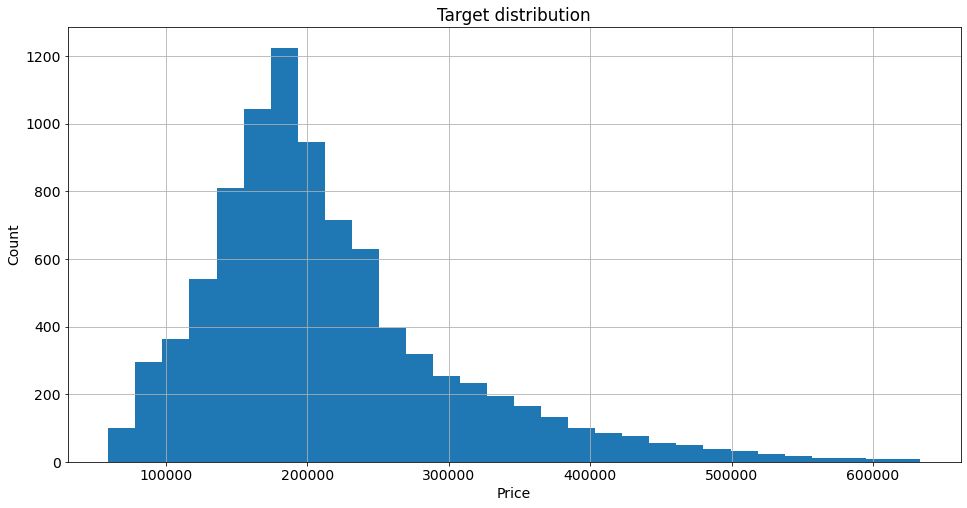

In [94]:
plt.figure(figsize = (16, 8))

train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

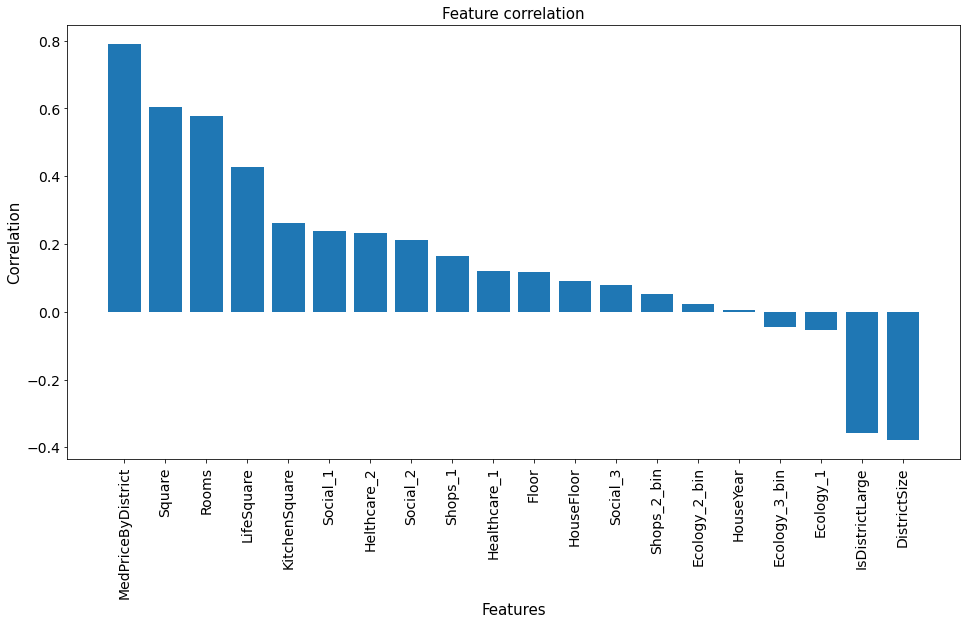

In [95]:
correlation = train.corrwith(train['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [106]:
train["Rooms_vc"] = train["Rooms"].map(train["Rooms"].value_counts().to_dict())
train["Rooms_vc"]

0       3537
1       1973
2       3537
3       3250
4       1973
        ... 
8876    3537
8877    3250
8878    3250
8879    3537
8880    3250
Name: Rooms_vc, Length: 8881, dtype: int64

#### Разбиение на train и test

In [107]:
X = train[feature_names + new_feature_names]
y = train[target_name]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### Построение модели

##### Обучение и оценка модели

In [109]:
rf_model = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

#### Отложенная выборка

In [111]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)



Train R2:	0.775
Test R2:	0.68


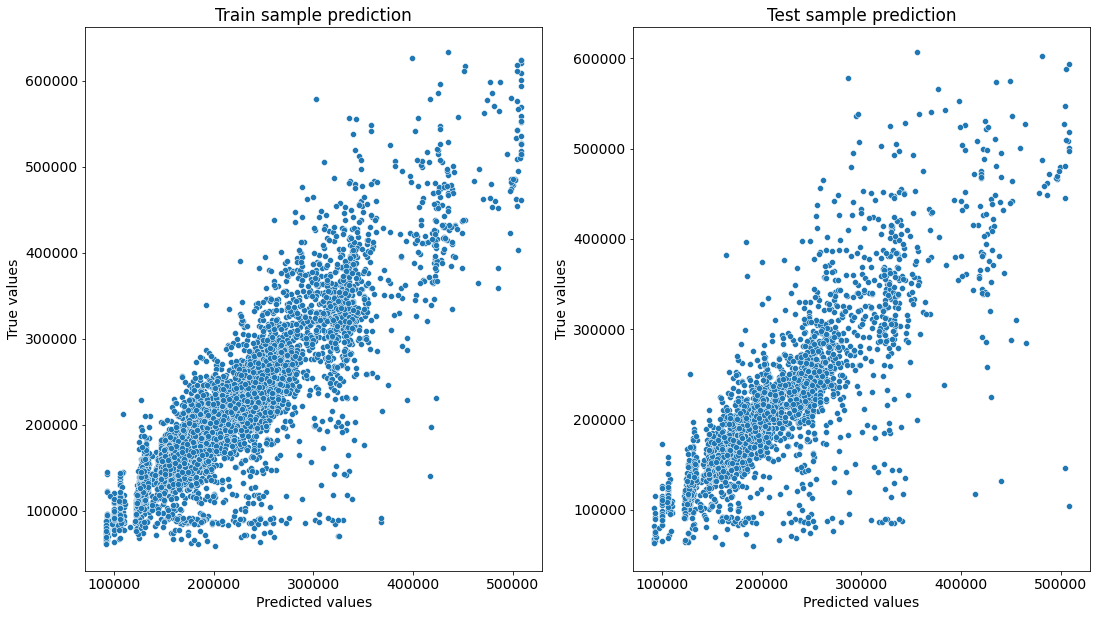

In [115]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

##### Важность признаков

In [117]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.809902
1,Square,0.111494
12,Social_3,0.014648
5,HouseFloor,0.010104
11,Social_2,0.008076
3,KitchenSquare,0.008030
10,Social_1,0.007772
13,Healthcare_1,0.006123
6,HouseYear,0.006120
4,Floor,0.005507


##### Формирование файла с прогнозами

In [118]:
test_id = test["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./predictions_.csv", index=False)

In [120]:
pred_df = pd.read_csv("./predictions_.csv")
pred_df.head(n=5)

,Id,Price
0,725,791571
1,15856,380600
2,5480,560968
3,15664,539167
4,14275,196408


In [122]:
test.shape[0]

5000